<a href="https://colab.research.google.com/github/zj71/AIAB/blob/main/AIAB_lab_sheet_3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center><b> Acquired Intelligence & Adaptive Behaviour </b></center></h1>
<h2><center><i>Evolving agents (Lab Sheet 03) </i></center></h2>

In this sheet we will take what we learned in the first two sheets to evolve a neural network which controls some agent. Your goal is to apply the GA your deveopled in the previous labs to this agent. The sheet includes an example of a single hillclimber which doesnt do very well. Once you have something working then experiment with different networks and different tasks.

We will be using the [`CartPole-v1`](https://gym.openai.com/envs/CartPole-v1/) task from `OpenAI` gym:


<center><img src="https://gym.openai.com/videos/2019-10-21--mqt8Qj1mwo/CartPole-v1/poster.jpg" width="300"></center>

> _A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center._


_If things stop working always try restarting the kernel, `opengl` does some strange things to Colab_



## Imports
(_We need to install some packages so we can render in Google colab_)

In [1]:
!apt-get update
!apt install xvfb 
!apt-get install x11-utils > /dev/null 2>&1
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [2]:
import random
import copy
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
import numpy as np
import torch

## OpenAI gym

Let's take a basic look at a `gym` agent loop. Here, we will just use random actions. The following envs which are relatively simple:

- `Acrobot-v1`
- `Cartpole-v1`
- `MountainCar-v0`
- `Pendulum-v0`

Note each environment will accept different actions and observations (see the lecture). Some accept discrete (`int`) actions and observations, some accept continuous (`float`) actions and observations. Use `env.action_space` and `env.observation_space`.

Here we will use `CartPole-v1`:

In [3]:
env_name = 'CartPole-v1'
env = gym.make(env_name) # create the gym environment
print(f"Action space {env.action_space} \nObservation space {env.observation_space}")

Action space Discrete(2) 
Observation space Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


**Action:** This means that the environment accepts a single number as an action, which is a discrete number in $[0, 1]$. Here, 0 corresponds to add a force of +1 to the card and 1 corresponds to adding a force -1 to cart. But the whole point of the `gym` hilosophy is that you don't need to know this. 

**Observation:** `Box` is a class from `gym`, it just means the observations will be wihtin some range (here -3.4 and 3.4), there will be 4 observations, and they will be continuous (`float32`). These 4 numbers corresponds to `

- position of cart
- velocity of cart
- angle of pole 
- rotation rate of pole 

But I had to Google that, good general-purpose agents don't need to know the semantics of the observations: they can learn how to map observations to actions to maximize reward without any prior knowledge.

Let's see how to run a `gym` environment. Two more concepts are needed here:

**Reset**: When you are learning agents, you need to run simulations hundreds (or billions if you are Google) times. Rather than create a new `env` instance each time, we can call `env.reset()` at the start of each simulation. 

**Done**: `gym` will tell you if the the simulations has finished. For instance, if you have died, or the time limit has been reached. You can also end the simulation yourself, but generally you rely on what `gym` says. Each time you call `env.step()` (coverered below) `gym` will tell you whether the simulations is finished or not

**Reward**: calling `env.step()` will also return how much reward you got for that time step. The amount of reward will vary for each environment, but all you need to know is that **more reward is better.** It will always a single floating point number. 

**Info**: `env.step()` also returns a dictionary called `info`. This sometimes contain additional information, but you can safely ignore it, 

**Step**: Brining this togetherm `env.step()` operates like this:

```python
obs, reward, done, info = env.step(action)
```

Here is an example ***(note I am just using random actions for now - there is no agent)***:

In [4]:
env_name = 'CartPole-v1'
env = gym.make(env_name)

env.reset()
done = False
while not done:
    action = env.action_space.sample() # put agent here
    obs, reward, done, info = env.step(action)
    print(f"obs{np.round(obs, 2)} reward {reward} action {action} done {done} info {info}")

obs[-0.01  0.15  0.03 -0.29] reward 1.0 action 1 done False info {}
obs[-0.01  0.34  0.02 -0.58] reward 1.0 action 1 done False info {}
obs[ 0.    0.54  0.01 -0.86] reward 1.0 action 1 done False info {}
obs[ 0.01  0.73 -0.01 -1.15] reward 1.0 action 1 done False info {}
obs[ 0.03  0.93 -0.03 -1.44] reward 1.0 action 1 done False info {}
obs[ 0.04  0.73 -0.06 -1.16] reward 1.0 action 0 done False info {}
obs[ 0.06  0.93 -0.08 -1.47] reward 1.0 action 1 done False info {}
obs[ 0.08  0.73 -0.11 -1.2 ] reward 1.0 action 0 done False info {}
obs[ 0.09  0.93 -0.13 -1.53] reward 1.0 action 1 done False info {}
obs[ 0.11  0.74 -0.16 -1.28] reward 1.0 action 0 done False info {}
obs[ 0.13  0.54 -0.19 -1.05] reward 1.0 action 0 done False info {}
obs[ 0.14  0.74 -0.21 -1.39] reward 1.0 action 1 done True info {}


It's best practice to wrap a single episode (or simulation, run, whatever you want to call it) in a function. The function will take the agent which we will create below, and which will have a `get_action` function which will take the observations generated by the environment. This function then returns the total reward from that episode. It is a type of **fitness function**:

In [5]:
def run_episode(env, agent):
    tot_reward = 0.0
    obs = env.reset()
    done = False
    while not done:
        action = agent.get_action(obs)
        obs, reward, done, info = env.step(action)
        tot_reward = tot_reward + reward
    return tot_reward

## Visualising your agent

It is normally very simple to visualise your simulations. But Google Colab makes it very hard. Here, I have provided a wrapper function which will visualise your episode. You don't need to understand it, and it's slow, so don't use it during learning (use it to view your agent after learning). 

Passing an agent to the function is optional. If you don't pass an agent, it selects actions at random

In [7]:
def visual_episode(env, agent=None):
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()
    prev_screen = env.render(mode='rgb_array')
    plt.imshow(prev_screen)

    tot_reward = 0.0
    obs = env.reset()
    done = False
    curr_t = 0
    while not done:
        if agent is not None:
            action = agent.get_action(obs)
        else:
            action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        screen = env.render(mode='rgb_array')
        tot_reward = tot_reward + reward

        plt.imshow(screen)
        plt.title(curr_t)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())
        curr_t = curr_t + 1

    ipythondisplay.clear_output(wait=True)
    env.close()
    return tot_reward


20.0

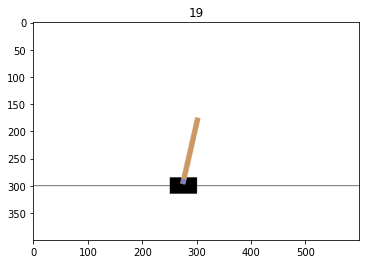

In [7]:
visual_episode(env)

https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t#scrollTo=TCelFzWY9MBI

In [8]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [9]:
env.close()

In [17]:

%matplotlib inline
import math
import glob
import io
import base64

from IPython.display import HTML

In [10]:
env = wrap_env(gym.make(env_name))
env.reset()
done = False
while not done:
    action = env.action_space.sample() # put agent here
    obs, reward, done, info = env.step(action)
    print(f"obs{np.round(obs, 2)} reward {reward} action {action} done {done} info {info}")

obs[-0.03 -0.23 -0.03  0.25] reward 1.0 action 0 done False info {}
obs[-0.04 -0.42 -0.03  0.54] reward 1.0 action 0 done False info {}
obs[-0.05 -0.23 -0.02  0.24] reward 1.0 action 1 done False info {}
obs[-0.05 -0.03 -0.01 -0.06] reward 1.0 action 1 done False info {}
obs[-0.05 -0.23 -0.01  0.23] reward 1.0 action 0 done False info {}
obs[-0.06 -0.03 -0.01 -0.07] reward 1.0 action 1 done False info {}
obs[-0.06  0.16 -0.01 -0.36] reward 1.0 action 1 done False info {}
obs[-0.05  0.36 -0.02 -0.66] reward 1.0 action 1 done False info {}
obs[-0.05  0.16 -0.03 -0.37] reward 1.0 action 0 done False info {}
obs[-0.04 -0.03 -0.04 -0.09] reward 1.0 action 0 done False info {}
obs[-0.04 -0.23 -0.04  0.19] reward 1.0 action 0 done False info {}
obs[-0.05 -0.42 -0.03  0.47] reward 1.0 action 0 done False info {}
obs[-0.06 -0.23 -0.02  0.17] reward 1.0 action 1 done False info {}
obs[-0.06 -0.03 -0.02 -0.13] reward 1.0 action 1 done False info {}
obs[-0.06 -0.23 -0.02  0.16] reward 1.0 action 0

In [15]:
def visual_episode3(env, agent=None):
    from pyvirtualdisplay import Display
    #display = Display(visible=0, size=(400, 300))
    #display.start()
    #prev_screen = env.render(mode='rgb_array')
    #plt.imshow(prev_screen)
    env.render(mode='rgb_array')
    tot_reward = 0.0
    obs = env.reset()
    done = False
    curr_t = 0
    while not done:
        if agent is not None:
            action = agent.get_action(obs)
        else:
            action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        #screen = env.render(mode='rgb_array')
        tot_reward = tot_reward + reward

        #plt.imshow(screen)
        #plt.title(curr_t)
        #ipythondisplay.clear_output(wait=True)
        #ipythondisplay.display(plt.gcf())
        curr_t = curr_t + 1

    #ipythondisplay.clear_output(wait=True)
    env.close()
    show_video()
    return tot_reward


In [18]:
visual_episode3(env)

17.0

## Agent

We can now move on to the idea of agents. We will need to make a way to map genotypes to agents. Our agents will use neural networks to select actions, so a natural method is to have the genes encode the weights and biases of your neural network.

Our agent will take the number of inputs (the number of observations from the environment) and map it to the number of outputs (in this case, a single action).

We will use the `set_gene` function to map a list of floats (our genes) of length `num_genes` (see the `Agent` class) to a set of weights and biases.

The output of this neural network will be a continuous. We will therefore map the number to a discrete output (0 or 1) by thresholding.
The rest of this class should be familiar from the previous work sheets.



In [ ]:
class Agent:
    def __init__(self, num_input, num_output):
        self.num_input = num_input 
        self.num_output = num_output
        self.num_genes = num_input * num_output + num_output
        self.weights = None
        self.bias = None

    def set_genes(self, gene):
        weight_idxs = self.num_input * self.num_output
        bias_idxs = self.num_input * self.num_output + self.num_output
        w = gene[0 : weight_idxs].reshape(self.num_output, self.num_input)   
        b = gene[weight_idxs: bias_idxs].reshape(self.num_output,)
        self.weights = torch.from_numpy(w)
        self.bias = torch.from_numpy(b)

    def forward(self, x):
        x = torch.from_numpy(x).unsqueeze(0)
        return torch.mm(x, self.weights.T) + self.bias

    def get_action(self, x):
        if self.forward(x) > 0:
            return 1
        else:
            return 0

Creating our agent is simple:

In [ ]:
num_obs = 4 # depends on your environment
num_actions = 1 # depends on your environment
agent = Agent(num_obs, num_actions)

## Learning your agent

We now need a way to change our genes in order to maximise reward. We will use the GA method, and you are encouraged to try different variants.

We can encode the populations of genes in the same way as previous weeks, The `Agent` class has a field called `num_genes`, this is how many genes you need. 

**Note that our gene are now continuous valued numbers, unlike last week**

In [ ]:
num_obs = 4 
num_actions = 1 
agent = Agent(num_obs, num_actions)

pop_size = 15
num_genes = agent.num_genes
gene_pop = np.random.normal(0, 0.1, (pop_size, num_genes))
# gene_pop = np.zeros((pop_size, num_genes))
print(f"{gene_pop.shape[0]} individuals in population, {gene_pop.shape[1]} genes per individual")

15 individuals in population, 5 genes per individual


## Fitness function

We want to maximise the reward from running our simulations. For each geneotype in our population, we map it to an agent, evaluate its reward, and return a list of rewards for each agent. 

In [ ]:
def fitness_function(env, agent, gene_pop):
    # Get fitness for each gene
    pop_size = gene_pop.shape[0]
    pop_fitness = np.zeros(pop_size)
    for i, gene in enumerate(gene_pop):
        agent.set_genes(gene)
        pop_fitness[i] = run_episode(env, agent)
    return pop_fitness

## Mutation 

We need some method for making mutations to genes. Below is an extremely simple example where we just add Gaussian noise, but we suggest you explore better methods

In [ ]:
def mutation_function(gene_pop, mean=0, std=0.1):
    for i, gene in enumerate(gene_pop):
        gene_pop[i] = gene_pop[i] + np.random.normal(mean, std, size=gene.shape)
    # constraint
    gene_pop[gene_pop > 4] = 4
    gene_pop[gene_pop < -4] = -4

    return gene_pop

## Selection

We also need some way to determine whether our mutation was benefical. Below is a simple function which takes the mutated value if it was an improvement, otherwise keeps the original value

In [ ]:
def select_genes(prev_gene_pop, gene_pop, prev_fitness, fitness):
    new_gene_pop = np.zeros_like(gene_pop)
    for i, gene in enumerate(gene_pop): 
        if fitness[i] >= prev_fitness[i]: 
            new_gene_pop[i] = gene_pop[i]
        else:
            new_gene_pop[i] = prev_gene_pop[i]

    return new_gene_pop

# Best gene

A function to get the best gene from a population. You may want to use that after the GA has run and you need to visualise the result.

In [ ]:
def get_best_gene(gene_pop, fitness):
    i = np.argmax(fitness)
    return gene_pop[i]

## Hill climbing

In [ ]:
# Parameters
epochs, pop_size, mutation_std = 1000, 15, 0.01
num_obs, num_actions = 4, 1 

# Create our agent
agent = Agent(num_obs, num_actions)

# Create our gene population
gene_pop = np.random.normal(0, 0.1, (pop_size, agent.num_genes))

# Get init fitness of the population
fitness = fitness_function(env, agent, gene_pop)

prev_fitness = fitness
prev_gene_pop = gene_pop

# Main loop
for epoch in range(epochs):
    # Mutate our population
    gene_pop = mutation_function(prev_gene_pop, std=mutation_std)

    # Get fitness of the population
    fitness = fitness_function(env, agent, gene_pop)

    # Apply selection 
    gene_pop = select_genes(prev_gene_pop, gene_pop, prev_fitness, fitness)

    prev_fitness = fitness
    prev_gene_pop = gene_pop

    if epoch % 100 == 0:
        print(f"Mean fitness of population {fitness.mean()}")
        print(f"Max fitness of population {fitness.max()}")

Mean fitness of population 15.2
Max fitness of population 55.0
Mean fitness of population 20.533333333333335
Max fitness of population 168.0
Mean fitness of population 12.066666666666666
Max fitness of population 29.0
Mean fitness of population 13.4
Max fitness of population 36.0
Mean fitness of population 10.8
Max fitness of population 25.0
Mean fitness of population 10.4
Max fitness of population 24.0
Mean fitness of population 9.666666666666666
Max fitness of population 15.0
Mean fitness of population 10.733333333333333
Max fitness of population 19.0
Mean fitness of population 17.466666666666665
Max fitness of population 62.0
Mean fitness of population 17.066666666666666
Max fitness of population 55.0


## Visualise agent

45.0

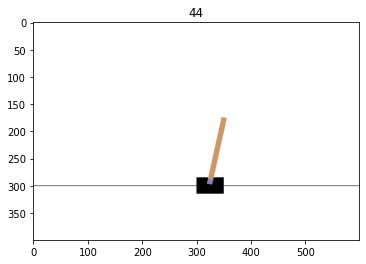

In [ ]:
# Visualise our agent
best_gene = get_best_gene(gene_pop, fitness)
agent.set_genes(best_gene)
visual_episode(env, agent)

# GA

In [19]:
class Agent:
    def __init__(self, num_input, num_output):
        self.num_input = num_input 
        self.num_output = num_output
        self.num_genes = num_input * num_output + num_output
        self.weights = None
        self.bias = None

    def set_genes(self, gene):
        weight_idxs = self.num_input * self.num_output
        bias_idxs = self.num_input * self.num_output + self.num_output
        w = gene[0 : weight_idxs].reshape(self.num_output, self.num_input)   
        b = gene[weight_idxs: bias_idxs].reshape(self.num_output,)
        self.weights = torch.from_numpy(w)
        self.bias = torch.from_numpy(b)

    def forward(self, x):
        x = torch.from_numpy(x).unsqueeze(0)
        return torch.mm(x, self.weights.T) + self.bias

    def get_action(self, x):
        if self.forward(x) > 0:
            return 1
        else:
            return 0

In [20]:
def fitness_function(env, agent, gene_pop):
    # Get fitness for each gene
    pop_size = gene_pop.shape[0]
    pop_fitness = np.zeros(pop_size)
    for i, gene in enumerate(gene_pop):
        agent.set_genes(gene)
        pop_fitness[i] = run_episode(env, agent)
    return pop_fitness

# tournament selection
def selection(pop, fit_value,k):

    #choose random point
    point=random.randint(0, len(pop)-1-k)
    # Pick individuals for tournament
    fighter1 = point
    fighter2 = random.randint(point+1, point+k)
    
    # Get fitness value for each
    fighter1_fitness = fit_value[fighter1]
    fighter2_fitness = fit_value[fighter2]
    
    # Identify undividual with highest fitness
    # Fighter 1 will win if score are equal
    if fighter1_fitness >= fighter2_fitness:
      winner_index = fighter1
      loser_index = fighter2
    else:
      winner_index = fighter2
      loser_index = fighter1
    
    # Return the winner,loser and index
    return winner_index, loser_index
 
# crossover two parents to create two children
def crossover(winner,loser, pc):
  
		# check for a crossover
  if np.random.rand() > pc:
			# Copy each gene of the winner W to the L
    loser = winner
      
  return loser
	
# mutation with flipping the number

def mutation(gene_pop,pm, mean=0, std=0.1):
  if np.random.rand() < pm:
    for i, gene in enumerate(gene_pop):
        gene_pop[i] = gene_pop[i] + np.random.normal(mean, std, size=gene.shape)
    # constraint
    gene_pop[gene_pop > 4] = 4
    gene_pop[gene_pop < -4] = -4

    return gene_pop

def get_best_gene(gene_pop, fitness):
    i = np.argmax(fitness)
    return gene_pop[i]



In [21]:
# Parameters
epochs = 1000
num_obs, num_actions = 4, 1
maxPop =  50 # number of chromosome
pc = 0.5			# crossover probability
pm = 0.05     # mutation probability
k=2    #pick a competitor from the local neighbourhood in the range k
results = []		# store results
fit_value = []		# fitness for each individual

In [22]:
# Create our agent
agent = Agent(num_obs, num_actions)

In [33]:
# Create our gene population
pop = np.random.normal(0, 0.1, (maxPop, agent.num_genes))

In [ ]:
pop

In [30]:
epochs=1000

In [34]:
fitness_history_mean,fitness_history_max=[],[]

# Get init fitness of the population
fit_value = fitness_function(env, agent, pop)

prev_fitness = fit_value
prev_pop = pop


# Main loop
for epoch in range(epochs):
    
    #create new pop list
    new_pop=[]
    new_pop=np.copy(pop)

    #selection
    winner_index,loser_index = selection(pop, fit_value,k)  
    
    #crossover
    new_loser= crossover(pop[winner_index],pop[loser_index], pc)

    #replace 
    new_pop[loser_index]=new_loser
    pop=new_pop
    
    #mutation
    mutation(pop[loser_index], pm)
    
  
    # Score best solution
    fit_value = fitness_function(env, agent, pop)
    prev_pop = pop
    
    fmax= np.max(fit_value)
    fmean = np.mean(fit_value) 
    fitness_history_mean.append(fmean)
    fitness_history_max.append(fmax)
    '''
    print('fit of epoch %s' % epoch)
    print(fit_value)
    '''
    
    if epoch == 0:
      pop1=pop
      fit_value1=fit_value
    if epoch == 500:
      pop2=pop
      fit_value2=fit_value
    if epoch == 999:
      pop3=pop
      fit_value3=fit_value

    if epoch % 100 == 0:
      print(f"Mean fitness of population {fmean}")
      print(f"Max fitness of population {fmax}")

Mean fitness of population 17.78
Max fitness of population 91.0
Mean fitness of population 26.2
Max fitness of population 99.0
Mean fitness of population 39.4
Max fitness of population 143.0
Mean fitness of population 45.12
Max fitness of population 109.0
Mean fitness of population 57.88
Max fitness of population 500.0
Mean fitness of population 58.14
Max fitness of population 313.0
Mean fitness of population 75.72
Max fitness of population 500.0
Mean fitness of population 93.68
Max fitness of population 500.0
Mean fitness of population 127.96
Max fitness of population 500.0
Mean fitness of population 176.06
Max fitness of population 500.0


### result and video

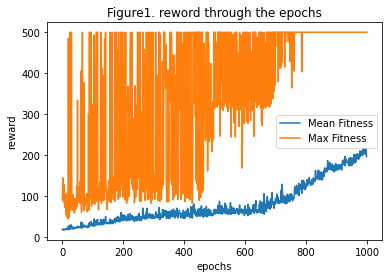

In [35]:
plt.plot(list(range(epochs)),fitness_history_mean, label = 'Mean Fitness')
plt.plot(list(range(epochs)),fitness_history_max, label = 'Max Fitness')
plt.legend()
plt.title('Figure1. reword through the epochs')
plt.xlabel('epochs')
plt.ylabel('reward')
plt.show()

In [40]:
# Visualise our agent
best_gene = get_best_gene(pop, fit_value)
agent.set_genes(best_gene)
visual_episode(env, agent)

500.0

In [36]:
def visual_episode2(env, agent=None):
    
    obs_velocity,obs_angle=[],[]

    
    tot_reward = 0.0
    obs = env.reset()
    done = False
    curr_t = 0
    while not done:
        if agent is not None:
            action = agent.get_action(obs)
        else:
            action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        
        obs_velocity.append(obs[1])
        obs_angle.append(obs[2])

        screen = env.render(mode='rgb_array')
        tot_reward = tot_reward + reward

        curr_t = curr_t + 1



    plt.plot(obs_velocity, label = 'velocity')
    plt.plot(obs_angle, label = 'angle')
    plt.legend()
    plt.title('velocity and angle through the times')
    plt.xlabel('times')
    plt.ylabel('obs')
    plt.show()
    
    env.close()
    return tot_reward

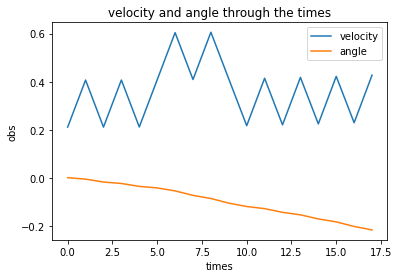

18.0

In [51]:
visual_episode2(env)

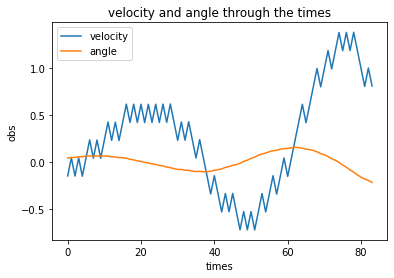

84.0

In [41]:
# Visualise our agent
best_gene = get_best_gene(pop1, fit_value1)
agent.set_genes(best_gene)
visual_episode2(env, agent)

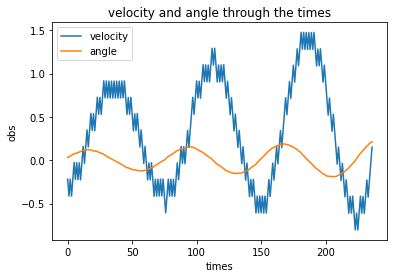

237.0

In [43]:
# Visualise our agent
best_gene = get_best_gene(pop2, fit_value2)
agent.set_genes(best_gene)
visual_episode2(env, agent)

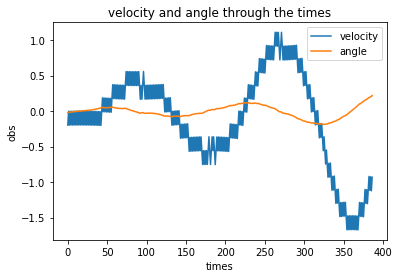

387.0

In [45]:
# Visualise our agent
best_gene = get_best_gene(pop3, fit_value3)
agent.set_genes(best_gene)
visual_episode2(env, agent)

# other playing

In [9]:
env.close()

In [10]:
env_name = 'MountainCar-v0'
env = gym.make(env_name)

env.reset()
done = False
while not done:
    action = env.action_space.sample() # put agent here
    obs, reward, done, info = env.step(action)
    print(f"obs{np.round(obs, 2)} reward {reward} action {action} done {done} info {info}")

obs[-0.57  0.  ] reward -1.0 action 1 done False info {}
obs[-0.57 -0.  ] reward -1.0 action 0 done False info {}
obs[-0.57 -0.  ] reward -1.0 action 0 done False info {}
obs[-0.57 -0.  ] reward -1.0 action 0 done False info {}
obs[-0.57 -0.  ] reward -1.0 action 1 done False info {}
obs[-0.57 -0.  ] reward -1.0 action 1 done False info {}
obs[-0.58 -0.  ] reward -1.0 action 0 done False info {}
obs[-0.58 -0.  ] reward -1.0 action 1 done False info {}
obs[-0.58 -0.  ] reward -1.0 action 0 done False info {}
obs[-0.58 -0.  ] reward -1.0 action 2 done False info {}
obs[-0.58  0.  ] reward -1.0 action 1 done False info {}
obs[-0.58  0.  ] reward -1.0 action 2 done False info {}
obs[-0.57  0.  ] reward -1.0 action 2 done False info {}
obs[-0.57  0.  ] reward -1.0 action 2 done False info {}
obs[-0.57  0.  ] reward -1.0 action 1 done False info {}
obs[-0.56  0.  ] reward -1.0 action 0 done False info {}
obs[-0.56  0.  ] reward -1.0 action 0 done False info {}
obs[-0.56  0.  ] reward -1.0 ac

In [11]:
visual_episode(env)

NameError: ignored